# model
> Model of the environment | System-Under-Steer
- order: 4

In [ ]:
#| default_exp model

In [ ]:
# Set up autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# from collections import namedtuple, defaultdict
from collections import defaultdict
# import numpy as np
import pandas as pd
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from copy import copy
# import time
# import math
# from pprint import pprint
## !pip install -U "ray"
# import ray
# import json

from fastcore.basics import patch
# from AIShiftScheduler_KE5.config import *
import AIShiftScheduler_KE5.config as cf
# from AIShiftScheduler_KE5.policy import *
import AIShiftScheduler_KE5.policy as pol
# from AIShiftScheduler_KE5.visualization import *
import AIShiftScheduler_KE5.visualization as vis


len(RESOURCE_TYPES)=3
['Manager', 'AssistMngr', 'RetailAssoc']

len(TYPES)=13
['Manager', 'AssistMngr', 'AssistMngr', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc']
len(aNAMES)=13
['Manager_Matt', 'AssistMngr_Mike', 'AssistMngr_Tanner', 'RetailAssoc_Jake', 'RetailAssoc_James', 'RetailAssoc_Jane', 'RetailAssoc_John', 'RetailAssoc_Jim', 'RetailAssoc_Jenny', 'RetailAssoc_Jeremy', 'RetailAssoc_Judy', 'RetailAssoc_Julie', 'RetailAssoc_Jeffrey']

len(bNAMES)=3
['Manager', 'AssistMngr', 'RetailAssoc']

len(abNAMES)=13
['Manager_Matt___Manager', 'AssistMngr_Mike___AssistMngr', 'AssistMngr_Tanner___AssistMngr', 'RetailAssoc_Jake___RetailAssoc', 'RetailAssoc_James___RetailAssoc', 'RetailAssoc_Jane___RetailAssoc', 'RetailAssoc_John___RetailAssoc', 'RetailAssoc_Jim___RetailAssoc', 'RetailAssoc_Jenny___RetailAssoc', 'RetailAssoc_Jeremy___RetailAssoc', 'RetailAssoc_Judy___RetailAssoc', 'RetailAsso

In [ ]:
pd.__version__

'2.0.3'

In [ ]:
# !pip freeze | grep pandas
# !pip freeze|grep openpyxl
# !pip freeze

In [ ]:
# !pip install -U ray==2.8.1
# !pip install openpyxl

In [ ]:
#| export
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
class MyClass(int): pass

In [ ]:
@patch
def func(self: MyClass, a): return self + a

In [ ]:
mc = MyClass(3)

In [ ]:
mc.func(10)

13

In [ ]:
#| export
class Model(): pass

In [ ]:
#| export
@patch
def __init__(self:Model, W_fn=None, S__M_fn=None, C_fn=None):
    self.S_t = {
      'R_t': pd.DataFrame({
        'ResourceId': cf.RESOURCE_IDS,
        'Type': cf.TYPES,
        'RAvail_t': cf.get_availabilities(pd.to_datetime(cf.START_DATE_TIME)),
        'RCumSlots_t': [0]*len(cf.TYPES), ##cumulative allocs (for T)
        # /////////////////////
        ## 'RMonthCumSlots_t': [0]*len(cf.TYPES),
        ## 'RWeekCumSlots_t': [0]*len(cf.TYPES),
        ## 'RUtil_t': [0]*len(cf.TYPES),
        # \\\\\\\\\
        'RCumMerits_t': [0]*len(cf.TYPES),
        'RComplete_t': [0]*len(cf.TYPES), ## 1/0: daily slot-run complete or not
      }),
      'D_t': pd.DataFrame({ ## Demands
        'Type': cf.RESOURCE_TYPES,
        ## base demand, due to D_n
        'DSlot_t': [1]*len(cf.RESOURCE_TYPES), ##why 1?
        ## demand due to busyness, i.e. foot traffic
        'DBusy_t': [0]*len(cf.RESOURCE_TYPES), 
        ## demand due to volume, number of items seems to correlate best with demand in general
        'DVolume_t': [0]*len(cf.RESOURCE_TYPES),
        ## demand due to revenue, e.g. high-value items requires more staff for approval for returns 
        'DRevenue_t': [0]*len(cf.RESOURCE_TYPES),
        ## demand max due to all sources
        'DMax_t': [0]*len(cf.RESOURCE_TYPES), 
      }),
      'M_t': pd.DataFrame({ ## Merits
        'ResourceId': cf.RESOURCE_IDS,
        'Type': cf.TYPES,
        'nMerits_t': [0]*len(cf.TYPES),
      }),
      'B_t': pd.DataFrame({ ## Busyness
        'Busy_t': [0],
      }),
      'V_t': pd.DataFrame({ ## Volume
        'Volume_t': [0],
      }),
      'N_t': pd.DataFrame({ ## Revenue
        'Revenue_t': [0],
      }),      
      'xAlloc_t_1': pd.DataFrame({ ##previous allocation
        'Comb': cf.abNAMES, ##Combination
        'Allocd_t': [False]*len(cf.abNAMES), ##Allocated
      }),
    }
    self.x_t = {
      'xAlloc_t': pd.DataFrame({
        'Comb': cf.abNAMES, ##Combination
        'Allocd_t': [False]*len(cf.abNAMES), ##Allocated
      }),
    }
    self.Ccum_CumSlots = 0.0
    self.Ccum_SickProb = 0.0
    self.Ccum_CumMerits = 0.0
    self.Ccum_ContSlots = 0.0
    self.Ccum = 0.0 ##cumulative reward

    self.Ucum_Total = 0 ##cumulative unallocated/unmet demands
    ##cumulative unallocated/unmet demands
    self.Ucum = {rt: 0 for rt in cf.RESOURCE_TYPES}
    self.W_tt1 = {}

In [ ]:
M = Model()

In [ ]:
# @patch
# def reset(self:Model):
#   self.Ccum = 0.0
#   self.Ucum = 0

In [ ]:
#| export
@patch
def W_fn(self:Model, t, dt): ## exogenous information
    return {
      ## 'demands': DEM.simulate(),
      ## 'demands': {'Courtesy': 2, 'Stocker': 1},
      'demands': { ## TAB function
        cf.RESOURCE_TYPES[int(col.split('_')[1])]: cf.EXOG_INFO.loc[cf.EXOG_INFO['Date'] == dt, col].squeeze() 
        for col in [f'D_{d}' for d in range(len(cf.RESOURCE_TYPES))]
      },
      ## 'merits': MER.simulate(),
      'merits': { ## TAB function
        cf.aNAMES[int(col.split('_')[1])]: cf.EXOG_INFO.loc[cf.EXOG_INFO['Date'] == dt, col].squeeze() 
        for col in [f'M_{m}' for m in range(len(cf.RESOURCE_IDS))]
      },
      'availabilities': cf.get_availabilities(dt), ## TAB function
      'busyness': cf.EXOG_INFO.loc[cf.EXOG_INFO['Date'] == dt, 'busyness'].squeeze(),
      'volume': cf.EXOG_INFO.loc[cf.EXOG_INFO['Date'] == dt, 'volume'].squeeze(),
      'revenue': cf.EXOG_INFO.loc[cf.EXOG_INFO['Date'] == dt, 'revenue'].squeeze()
    }

In [ ]:
t = 7

In [ ]:
dt = pd.to_datetime(cf.START_DATE_TIME); dt

Timestamp('2023-12-04 00:00:00')

In [ ]:
M.W_fn(t, dt)

{'demands': {'Manager': 0, 'AssistMngr': 0, 'RetailAssoc': 0},
 'merits': {'Manager_Matt': 0,
  'AssistMngr_Mike': 1,
  'AssistMngr_Tanner': 0,
  'RetailAssoc_Jake': 0,
  'RetailAssoc_James': 1,
  'RetailAssoc_Jane': 0,
  'RetailAssoc_John': 0,
  'RetailAssoc_Jim': 0,
  'RetailAssoc_Jenny': 0,
  'RetailAssoc_Jeremy': 0,
  'RetailAssoc_Judy': 0,
  'RetailAssoc_Julie': 0,
  'RetailAssoc_Jeffrey': 0},
 'availabilities': 0     0
 1     0
 2     0
 3     0
 4     0
 5     0
 6     0
 7     0
 8     0
 9     0
 10    0
 11    0
 12    0
 Name: 0, dtype: int64,
 'busyness': 0,
 'volume': 0,
 'revenue': 0.0}

In [ ]:
#| export
@patch
def update_Ccum(self:Model, t, dt, S_t, x_t, theta):
    ## dow, hod = ((t + 1)//24)%7, (t + 1)%24; ##print(f'{dow=}, {hod=}')
    ## dow, qod = ((t + 1)//96)%7, (t + 1)%96; ##print(f'{dow=}, {qod=}')
    dow, sod = ((t + 1)//cf.SLOTS_PER_DAY)%7, (t + 1)%cf.SLOTS_PER_DAY; ##print(f'{dow=}, {sod=}')
    m1 = \
      x_t['xAlloc_t'].merge(
      S_t['R_t']\
       [['RCumSlots_t', 'RAvail_t', 'RCumMerits_t']],
       left_index=True, right_index=True)

    ## merge in previous allocations
    m1a = \
      S_t['xAlloc_t_1'].merge(
      m1[['Allocd_t', 'RCumSlots_t', 'RAvail_t', 'RCumMerits_t']],
      left_index=True, right_index=True)
    m1a.rename(columns={'Allocd_t_x': 'Allocd_t_1', 'Allocd_t_y': 'Allocd_t'}, inplace=True)

    m2 = \
      m1a.merge(
      cf.SICK_PROBS[[dt.month_name()]],
      left_index=True, right_index=True)
    m2.rename(columns={dt.month_name(): 'SickProb'}, inplace=True)

    m2['Capacity'] = pd.DataFrame({'Capacity': cf.get_capacities(dow)})
    m2['Ccum_CumSlots'] = -(m2['RCumSlots_t'] - m2['Capacity'])

    ## m2['Ccum_SickProb'] = -100*m2['SickProb']
    ## m2['Ccum_SickProb'] = -100*(m2['SickProb'] - m2['SickProb'].mean()) ##100 makes values more comparable with other component of Ccum
    m2['Ccum_SickProb'] = -1*(m2['SickProb'] - m2['SickProb'].mean()) ##100 makes values more comparable with other component of Ccum

    m2['Ccum_CumMerits'] = m2['RCumMerits_t']

    m2.loc[ ## contiguous slots
      (m2['Allocd_t'] == True) & \
      (m2['Allocd_t'] == m2['Allocd_t_1']),
      ['Ccum_ContSlots']
    ] = cf.CONTIGUOUS_REWARD ## reward if shift is continued without interuption

    summables = m2.loc[
      m2['Allocd_t'] == True,
      ['Ccum_CumSlots', 'Ccum_SickProb', 'Ccum_CumMerits', 'Ccum_ContSlots'],
    ]
    Ccum_CumSlots, Ccum_SickProb, Ccum_CumMerits, Ccum_ContSlots = summables.sum(axis=0)
    Ccum = \
      theta.thCumSlots*Ccum_CumSlots + \
      theta.thSickProb*Ccum_SickProb + \
      theta.thCumMerits*Ccum_CumMerits + \
      theta.thContSlots*Ccum_ContSlots
    self.Ccum_CumSlots += Ccum_CumSlots
    self.Ccum_SickProb += Ccum_SickProb
    self.Ccum_CumMerits += Ccum_CumMerits
    self.Ccum_ContSlots += Ccum_ContSlots
    self.Ccum += Ccum

    ##resource expense (what you pay them)
    tmp = x_t['xAlloc_t'].loc[
      x_t['xAlloc_t']['Allocd_t'] == True,
    ]
    tmp = tmp.copy()
    tmp['type'] = tmp.apply(lambda row: row.Comb.split('_')[0], axis=1)
    tmp['expense'] = tmp.apply(lambda row: cf.RESOURCE_EXPENSE[row.type], axis=1)
    expense = tmp['expense'].sum()
    self.Ccum -= expense
    
    ## real revenue or forecast
    self.Ccum += self.W_tt1['revenue']

In [ ]:
m = Model(); m

<__main__.Model>

In [ ]:
t = 8
dt = pd.to_datetime(cf.START_DATE_TIME); dt

Timestamp('2023-12-04 00:00:00')

In [ ]:
S_t = m.S_t; S_t

{'R_t':    ResourceId         Type  RAvail_t  RCumSlots_t  RCumMerits_t  RComplete_t
 0        Matt      Manager         0            0             0            0
 1        Mike   AssistMngr         0            0             0            0
 2      Tanner   AssistMngr         0            0             0            0
 3        Jake  RetailAssoc         0            0             0            0
 4       James  RetailAssoc         0            0             0            0
 5        Jane  RetailAssoc         0            0             0            0
 6        John  RetailAssoc         0            0             0            0
 7         Jim  RetailAssoc         0            0             0            0
 8       Jenny  RetailAssoc         0            0             0            0
 9      Jeremy  RetailAssoc         0            0             0            0
 10       Judy  RetailAssoc         0            0             0            0
 11      Julie  RetailAssoc         0            0       

In [ ]:
x_t = m.x_t; x_t

{'xAlloc_t':                                  Comb  Allocd_t
 0              Manager_Matt___Manager     False
 1        AssistMngr_Mike___AssistMngr     False
 2      AssistMngr_Tanner___AssistMngr     False
 3      RetailAssoc_Jake___RetailAssoc     False
 4     RetailAssoc_James___RetailAssoc     False
 5      RetailAssoc_Jane___RetailAssoc     False
 6      RetailAssoc_John___RetailAssoc     False
 7       RetailAssoc_Jim___RetailAssoc     False
 8     RetailAssoc_Jenny___RetailAssoc     False
 9    RetailAssoc_Jeremy___RetailAssoc     False
 10     RetailAssoc_Judy___RetailAssoc     False
 11    RetailAssoc_Julie___RetailAssoc     False
 12  RetailAssoc_Jeffrey___RetailAssoc     False}

In [ ]:
P = pol.Policy(M)

In [ ]:
theta = P.build_theta({
  'thCumSlots': .1,
  'thSickProb': .3,
  'thCumMerits': .2,
  'thContSlots': 1 - (.6),
  'thSelect': 'random'
}); theta

Theta(thCumSlots=0.1, thSickProb=0.3, thCumMerits=0.2, thContSlots=0.4, thSelect='random')

In [ ]:
#| export
@patch
def performAllocDecision(self:Model, S_t, x_t, theta):
    ## find list of ResourceIds for allocs from x_t
    resourceIds = x_t['xAlloc_t'].loc[
      x_t['xAlloc_t']['Allocd_t']==True,
      ['Comb']
    ]['Comb'].str.split('_').str[1:2].tolist(); ##print(f'{resourceIds=}')
    resourceIds_flat = [e[0] for e in resourceIds]; ##print(f'{resourceIds_flat=}')

    ## update state of allocs
    S_t['R_t'].loc[
      S_t['R_t']['ResourceId'].isin(resourceIds_flat),
      ['RAvail_t']
    ] = 0
    S_t['R_t'].loc[
      S_t['R_t']['ResourceId'].isin(resourceIds_flat),
      ['RCumSlots_t']
    ] += 1

    ## update Ccum with allocations
    ## self.Ccum += len(resourceIds_flat) #number of allocations

In [ ]:
#| export
@patch
def S__M_fn(self:Model, t, dt, S_t, x_t, W_tt1, theta):
    ## dow, hod = ((t + 1)//24)%7, (t + 1)%24; ##print(f'{dow=}, {hod=}')
    ## dow, qod = ((t + 1)//96)%7, (t + 1)%96; ##print(f'{dow=}, {qod=}')
    dow, sod = ((t + 1)//cf.SLOTS_PER_DAY)%7, (t + 1)%cf.SLOTS_PER_DAY; ##print(f'{dow=}, {sod=}')

    ## perform decision taken this morning
    self.performAllocDecision(S_t, x_t, theta)

    ## Update state from exogenous information
    for an in cf.aNAMES:
      resId = an.split('_')[1]
      merits = W_tt1['merits'][an]
      S_t['M_t'].loc[S_t['M_t']['ResourceId'] == resId, 'nMerits_t'] = merits
    S_t['R_t']['RAvail_t'] = W_tt1['availabilities']
    ## base demands
    for rt in cf.RESOURCE_TYPES:
      rt_demands = W_tt1['demands'][rt]
      S_t['D_t'].loc[S_t['D_t']['Type'] == rt, 'DSlot_t'] = rt_demands
    ## busyness demands  
    busyness = W_tt1['busyness'] 
    S_t['B_t']['Busy_t'] = busyness
    for rt in cf.RESOURCE_TYPES:
      rt_demands = cf.DEMAND_PER_BUSYNESS[rt]*busyness
      S_t['D_t'].loc[S_t['D_t']['Type'] == rt, 'DBusy_t'] = rt_demands
    ## volume demands
    volume = W_tt1['volume'] 
    S_t['V_t']['Volume_t'] = volume
    for rt in cf.RESOURCE_TYPES:
      rt_demands = cf.DEMAND_PER_VOLUME[rt]*volume
      S_t['D_t'].loc[S_t['D_t']['Type'] == rt, 'DVolume_t'] = rt_demands
    ## revenue demands
    revenue = W_tt1['revenue']
    S_t['N_t']['Revenue_t'] = revenue
    for rt in cf.RESOURCE_TYPES:
      rt_demands = cf.DEMAND_PER_REVENUE[rt]*revenue
      S_t['D_t'].loc[S_t['D_t']['Type'] == rt, 'DRevenue_t'] = rt_demands    

    for rt in cf.RESOURCE_TYPES:
      number = S_t['D_t'].loc[
        S_t['D_t']['Type']==rt,
        ['DSlot_t', 'DBusy_t', 'DVolume_t', 'DRevenue_t']
      ].max(axis=1).squeeze() ##max the contributions of each demand
      ## ].sum(axis=1).squeeze() ##sum the contributions of each demand
      S_t['D_t'].loc[S_t['D_t']['Type'] == rt, 'DMax_t'] = number

    ## Update cumulative merits of all resources
    S_t['R_t']['RCumMerits_t'] += S_t['M_t']['nMerits_t']

    ## Update RComplete_t
    m1 = \
      S_t['xAlloc_t_1'].merge(
      x_t['xAlloc_t'],
      left_index=True, right_index=True)
    m1.rename(columns={'Comb_x': 'Comb', 'Allocd_t_x': 'Allocd_t_1', 'Allocd_t_y': 'Allocd_t'}, inplace=True)
    m1.drop('Comb_y', inplace=True, axis=1)
    m2 = m1.loc[(m1['Allocd_t_1'] == True) & (m1['Allocd_t'] == False)]
    resourceIds = m2.loc[
      (m2['Allocd_t_1'] == True) & (m2['Allocd_t'] == False),
      ['Comb']
    ]['Comb'].str.split('_').str[1:2].tolist(); ##print(f'{resourceIds=}')
    resourceIds_flat = [e[0] for e in resourceIds]; ##print(f'{resourceIds_flat=}')
    S_t['R_t'].loc[
      S_t['R_t']['ResourceId'].isin(resourceIds_flat),
      ['RComplete_t']
    ] = 1

    ## Update 'xAlloc_t_1'
    S_t['xAlloc_t_1'] = copy(x_t['xAlloc_t']) ## SG

    # ## Reset for new month
    # if dt.is_month_start:
    #   S_t['R_t']['RMonthCumSlots_t'] = 0

    # ## Reset for new week
    # if dow == 0:
    #   S_t['R_t']['RMonthCumSlots_t'] += S_t['R_t']['RWeekCumSlots_t']
    #   S_t['R_t']['RWeekCumSlots_t'] = 0

    ## Reset for new day
    if sod == 0: ## slot-of-day
      S_t['R_t']['RCumSlots_t'] = 0; ##print(f'%%% Resetting RCumSlots_t ...')
      ## S_t['R_t']['RWeekCumSlots_t'] += S_t['R_t']['RCumSlots_t']
      ## S_t['R_t']['RCumSlots_t'] = 0; ##print(f'%%% Resetting RCumSlots_t ...')

      S_t['R_t']['RComplete_t'] = 0
      self.Ucum = {rt: 0 for rt in cf.RESOURCE_TYPES}
      self.Ucum_Total = 0
      self.Ccum_CumSlots = 0.0
      ## self.Ccum_SickProb = 0.0
      ## self.Ccum_CumMerits = 0.0
      self.Ccum_ContSlots = 0.0
      ## self.Ccum = 0.0

    record_t = [t, dt] + \
      list(S_t['R_t']['RAvail_t']) + \
      list(S_t['R_t']['RCumSlots_t']) + \
      list(S_t['R_t']['RCumMerits_t']) + \
      list(S_t['R_t']['RComplete_t']) + \
      list(S_t['D_t']['DSlot_t']) + \
      list(S_t['D_t']['DBusy_t']) + \
      list(S_t['D_t']['DVolume_t']) + \
      list(S_t['D_t']['DRevenue_t']) + \
      list(S_t['D_t']['DMax_t']) + \
      list(S_t['B_t']['Busy_t']) + \
      list(S_t['V_t']['Volume_t']) + \
      list(S_t['N_t']['Revenue_t']) + \
      [self.Ucum[rt] for rt in cf.RESOURCE_TYPES] + \
      [self.Ucum_Total] + \
      [self.Ccum_CumSlots] + \
      [self.Ccum_SickProb] + \
      [self.Ccum_CumMerits] + \
      [self.Ccum_ContSlots] + \
      [self.Ccum] + \
      list(x_t['xAlloc_t']['Allocd_t'])
    return record_t

In [ ]:
#| export
@patch
def C_fn(self:Model, S_t, x_t, W_tt1, theta):
    return

In [ ]:
#| export
@patch
def step(self:Model, t, dt, theta):
    ## IND = '\t\t'
    ## print(f"{IND}..... M. step() .....\n{t=}\n{theta=}")
    self.W_tt1 = self.W_fn(t, dt); ##print(f'%%% {W_tt1=}')

    ## update state & reward
    record_t = self.S__M_fn(t, dt, self.S_t, self.x_t, self.W_tt1, theta)
    return record_t

## Usage

In [ ]:
# hide
# QUICK STEP
def print_S_t():
  print(f'M.S_t["R_t"]=\n{M.S_t["R_t"]}')
  print(f'M.S_t["D_t"]=\n{M.S_t["D_t"]}')

def print_x_t():
  # print(f'x_t.x_t= {x_t.x_t}')
  print(f'M.x_t["xAlloc_t"]=\n{M.x_t["xAlloc_t"]}')

record = []
l = 1
M = Model()
P = pol.Policy(M)
## DEM = DemandSimulator(seed=SEED_TRAIN); print(f'{DEM.simulate()=}')
## MER = MeritSimulator(seed=SEED_TRAIN); print(f'{MER.simulate()=}')

theta_test = P.build_theta({
  'thCumSlots': .1,
  'thSickProb': .3,
  'thCumMerits': .2,
  'thContSlots': 1 - (.6),
  'thSelect': 'random'
})
record_l = [cf.piNAMES[0], theta_test, l]; print(f'{record_l=}')
print_S_t()
print_x_t()

record_l=['X__Alloc', Theta(thCumSlots=0.1, thSickProb=0.3, thCumMerits=0.2, thContSlots=0.4, thSelect='random'), 1]
M.S_t["R_t"]=
   ResourceId         Type  RAvail_t  RCumSlots_t  RCumMerits_t  RComplete_t
0        Matt      Manager         0            0             0            0
1        Mike   AssistMngr         0            0             0            0
2      Tanner   AssistMngr         0            0             0            0
3        Jake  RetailAssoc         0            0             0            0
4       James  RetailAssoc         0            0             0            0
5        Jane  RetailAssoc         0            0             0            0
6        John  RetailAssoc         0            0             0            0
7         Jim  RetailAssoc         0            0             0            0
8       Jenny  RetailAssoc         0            0             0            0
9      Jeremy  RetailAssoc         0            0             0            0
10       Judy  RetailA

In [ ]:
## hide
# T = 7*24
# T = 2*24
T = 2
# T = 1*SLOTS_PER_DAY
# T = 2*SLOTS_PER_DAY
dt = pd.to_datetime(cf.START_DATE_TIME)
dt_delta = pd.Timedelta(cf.DATE_TIME_DELTA)
for t in range(T):
  print(f'\n################# t={t}, dt={dt} #################')
  # getattr(P, 'X__AllocBelow')(t, M.S_t, M.x_t, theta_test); #print(f'{x_t=}')
  getattr(P, 'X__Alloc')(t, dt, M.S_t, M.x_t, theta_test); #print(f'{x_t=}')
  print_S_t()
  print_x_t()

  # record_t = M.step(t, theta_test)
  record_t = M.step(t, dt, theta_test)
  print(f'\nAFTER STEP:')
  record.append(record_l + record_t); #print(f'{record=}')
  dt = dt + dt_delta
  # print_S_t()
  # print(f'{M.Ccum=}')


################# t=0, dt=2023-12-04 00:00:00 #################
M.S_t["R_t"]=
   ResourceId         Type  RAvail_t  RCumSlots_t  RCumMerits_t  RComplete_t
0        Matt      Manager         0            0             0            0
1        Mike   AssistMngr         0            0             0            0
2      Tanner   AssistMngr         0            0             0            0
3        Jake  RetailAssoc         0            0             0            0
4       James  RetailAssoc         0            0             0            0
5        Jane  RetailAssoc         0            0             0            0
6        John  RetailAssoc         0            0             0            0
7         Jim  RetailAssoc         0            0             0            0
8       Jenny  RetailAssoc         0            0             0            0
9      Jeremy  RetailAssoc         0            0             0            0
10       Judy  RetailAssoc         0            0             0           

In [ ]:
## hide
V = vis.Visualization()
Labels = V.setup_plot_labels()

In [ ]:
df_test_n_t = pd.DataFrame.from_records(record, columns=Labels)
df_test_n_t.tail()

,piName,theta,l,t,dt,RAvail_t_Manager_Matt,RAvail_t_AssistMngr_Mike,RAvail_t_AssistMngr_Tanner,RAvail_t_RetailAssoc_Jake,RAvail_t_RetailAssoc_James,RAvail_t_RetailAssoc_Jane,RAvail_t_RetailAssoc_John,RAvail_t_RetailAssoc_Jim,RAvail_t_RetailAssoc_Jenny,RAvail_t_RetailAssoc_Jeremy,RAvail_t_RetailAssoc_Judy,RAvail_t_RetailAssoc_Julie,RAvail_t_RetailAssoc_Jeffrey,RCumSlots_t_Manager_Matt,RCumSlots_t_AssistMngr_Mike,RCumSlots_t_AssistMngr_Tanner,RCumSlots_t_RetailAssoc_Jake,RCumSlots_t_RetailAssoc_James,RCumSlots_t_RetailAssoc_Jane,RCumSlots_t_RetailAssoc_John,RCumSlots_t_RetailAssoc_Jim,RCumSlots_t_RetailAssoc_Jenny,RCumSlots_t_RetailAssoc_Jeremy,RCumSlots_t_RetailAssoc_Judy,RCumSlots_t_RetailAssoc_Julie,RCumSlots_t_RetailAssoc_Jeffrey,RCumMerits_t_Manager_Matt,RCumMerits_t_AssistMngr_Mike,RCumMerits_t_AssistMngr_Tanner,RCumMerits_t_RetailAssoc_Jake,RCumMerits_t_RetailAssoc_James,RCumMerits_t_RetailAssoc_Jane,RCumMerits_t_RetailAssoc_John,RCumMerits_t_RetailAssoc_Jim,RCumMerits_t_RetailAssoc_Jenny,RCumMerits_t_RetailAssoc_Jeremy,RCumMerits_t_RetailAssoc_Judy,RCumMerits_t_RetailAssoc_Julie,RCumMerits_t_RetailAssoc_Jeffrey,RComplete_t_Manager_Matt,RComplete_t_AssistMngr_Mike,RComplete_t_AssistMngr_Tanner,RComplete_t_RetailAssoc_Jake,RComplete_t_RetailAssoc_James,RComplete_t_RetailAssoc_Jane,RComplete_t_RetailAssoc_John,RComplete_t_RetailAssoc_Jim,RComplete_t_RetailAssoc_Jenny,RComplete_t_RetailAssoc_Jeremy,RComplete_t_RetailAssoc_Judy,RComplete_t_RetailAssoc_Julie,RComplete_t_RetailAssoc_Jeffrey,DSlot_t_Manager,DSlot_t_AssistMngr,DSlot_t_RetailAssoc,DBusy_t_Manager,DBusy_t_AssistMngr,DBusy_t_RetailAssoc,DVolume_t_Manager,DVolume_t_AssistMngr,DVolume_t_RetailAssoc,DRevenue_t_Manager,DRevenue_t_AssistMngr,DRevenue_t_RetailAssoc,DMax_t_Manager,DMax_t_AssistMngr,DMax_t_RetailAssoc,B_t,V_t,N_t,Ucum_Manager,Ucum_AssistMngr,Ucum_RetailAssoc,Ucum_Total,Ccum_CumSlots,Ccum_SickProb,Ccum_CumMerits,Ccum_ContSlots,Ccum,Allocd_t_Manager_Matt___Manager,Allocd_t_AssistMngr_Mike___AssistMngr,Allocd_t_AssistMngr_Tanner___AssistMngr,Allocd_t_RetailAssoc_Jake___RetailAssoc,Allocd_t_RetailAssoc_James___RetailAssoc,Allocd_t_RetailAssoc_Jane___RetailAssoc,Allocd_t_RetailAssoc_John___RetailAssoc,Allocd_t_RetailAssoc_Jim___RetailAssoc,Allocd_t_RetailAssoc_Jenny___RetailAssoc,Allocd_t_RetailAssoc_Jeremy___RetailAssoc,Allocd_t_RetailAssoc_Judy___RetailAssoc,Allocd_t_RetailAssoc_Julie___RetailAssoc,Allocd_t_RetailAssoc_Jeffrey___RetailAssoc
0,X__Alloc,"(0.1, 0.3, 0.2, 0.4, random)",1,0,2023-12-04 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,False,False,False,False,False,False,False,False,False,False,False
1,X__Alloc,"(0.1, 0.3, 0.2, 0.4, random)",1,1,2023-12-04 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1,1,0,0,0,-1,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,False,False,False,False,False,False,False,False,False,False,False


/Users/kobus/AIShiftScheduler_KE5/AIShiftScheduler_KE5/visualization.py:429: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[xi+i].set_ylim(0, ymax); axs[xi+i].spines['top'].set_visible(False); axs[xi+i].spines['right'].set_visible(True); axs[xi+i].spines['bottom'].set_visible(False)


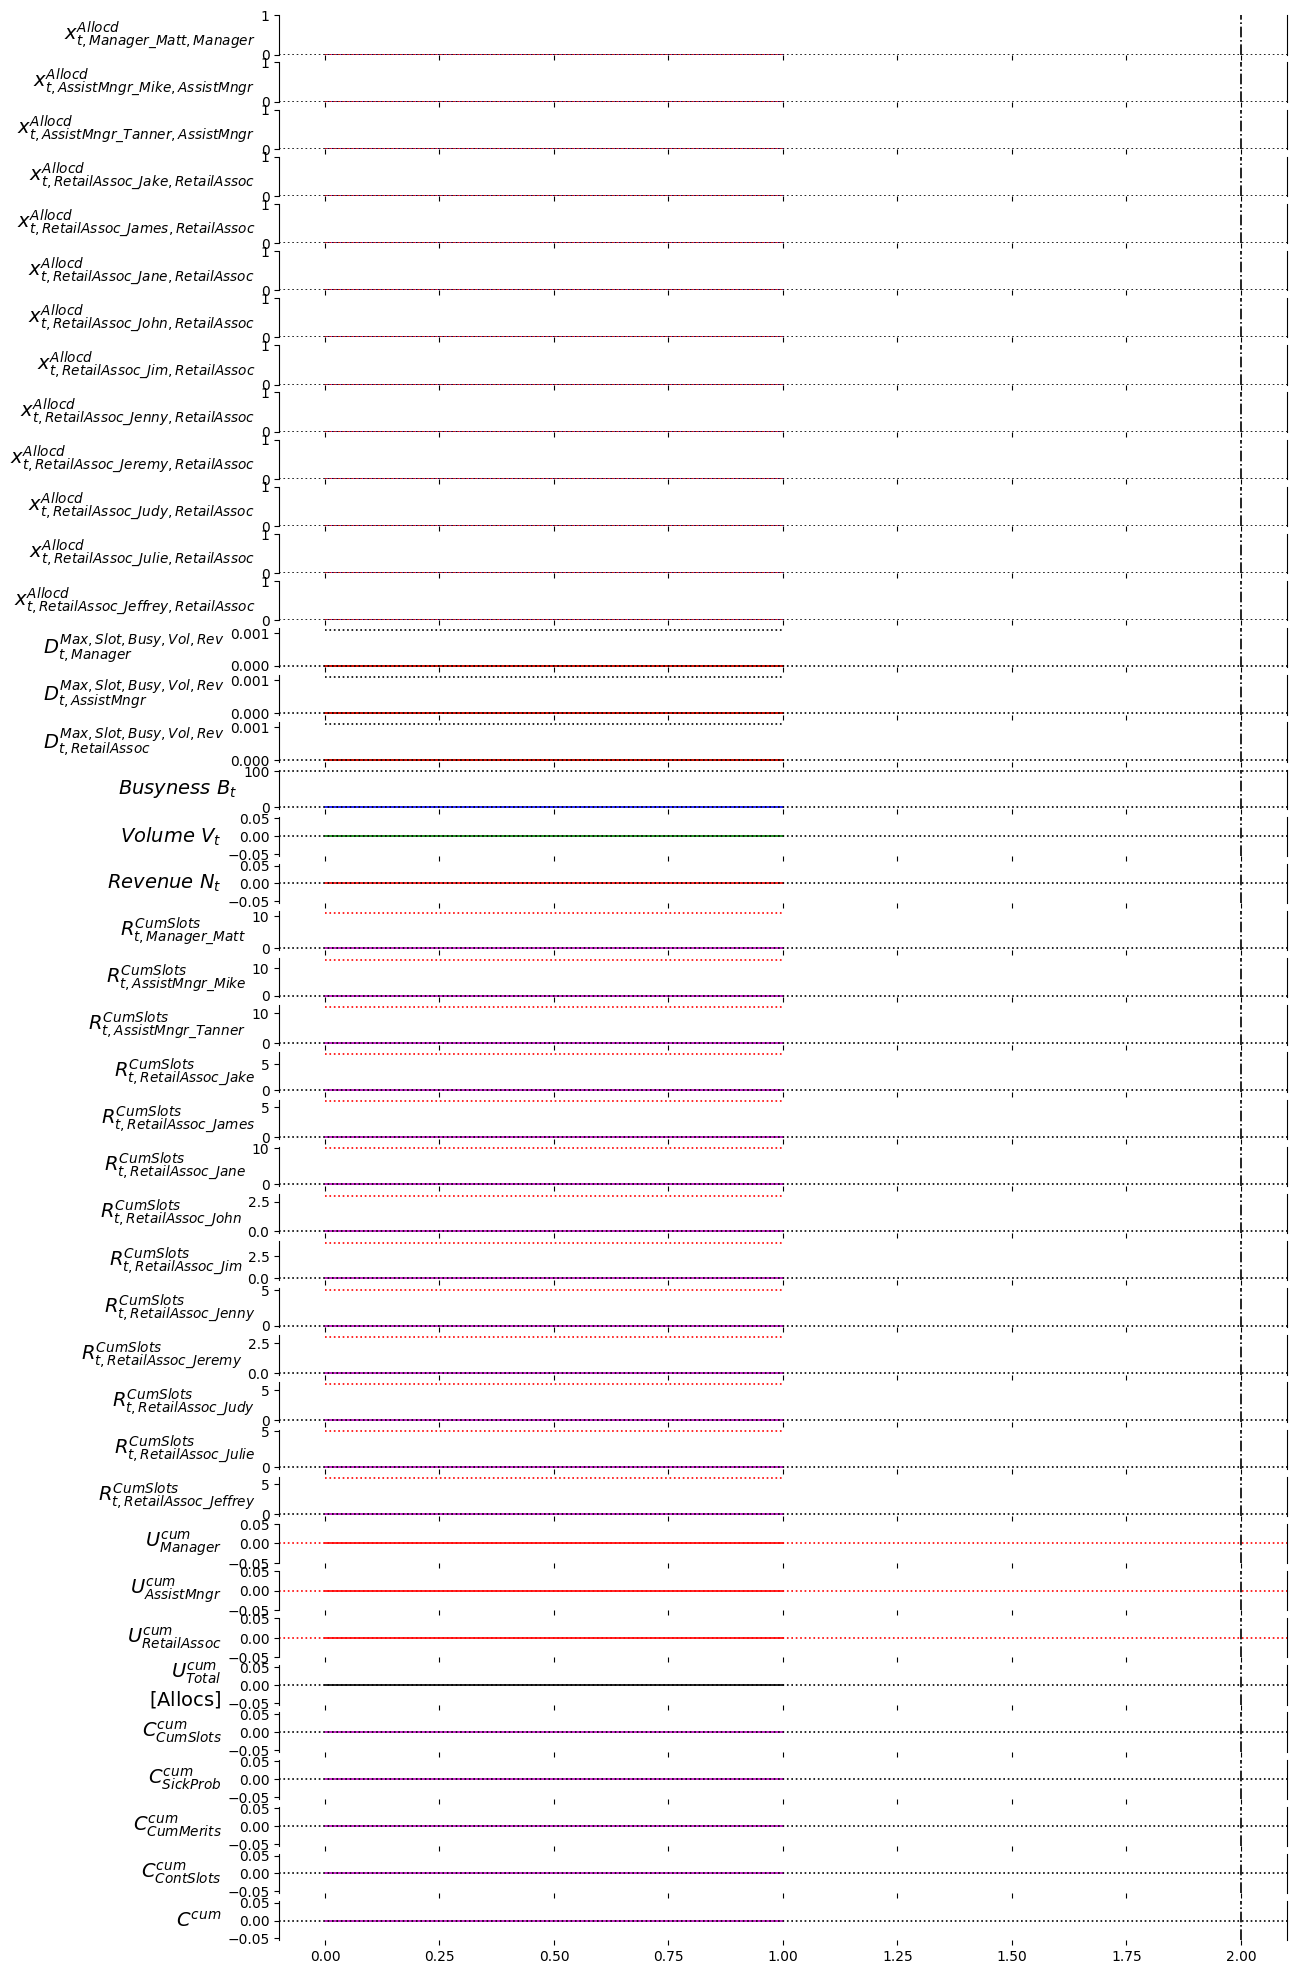

In [ ]:
## hide
V.plot_records(
  df=df_test_n_t,
  df_non=None,
  pars=defaultdict(str, {
    # 'thetaAdj1': {a1n: theta_test.thAdj1[a1n] for a1n in a1NAMES},
    # 'thetaAdj3': {a1n: theta_test.thAdj3[a1n] for a1n in a1NAMES},
    # 'suptitle': f'TRAINING OF X__AdjBelow POLICY'+'\n'+f'(first {first_n_t} records)'+'\n'+ \
    # f'L = {L}, T = {T}, '+ \
    # r'$\theta^*=$'+f'{P.round_theta(best_theta_AdjBelow)}',
    'T': T
  }),
)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()